In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator

In [26]:
class IsingModel:
    def __init__(self, L, T):
        #parâmetros do modelo
        self.L = L
        self.T = T

        #array com os spins
        self.spins = np.ones((L,L))

        #arrays para guardar evoluções das variáveis
        self.energies= [self.calc_ener_total()]
        self.magnetizations= [L**2]

        #energia e magnetização total
        self.energy_total = self.calc_ener_total()
        self.magnet_total = np.sum(self.spins)

    def calc_ener_spin(self, i, j):
        #calcular a energia de um spin
        spin= self.spins[i,j]
        neighbours= (
        self.spins[(i+1)%self.L, j] + 
        self.spins[i, (j+1)%self.L] + 
        self.spins[(i-1)%self.L, j] + 
        self.spins[i, (j-1)%self.L]
        )
        energy=-spin*neighbours
        return energy
    
    def calc_ener_total( self ):
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                energy+= -self.spins[i,j]*(self.spins[(i+1)%self.L,j]+ self.spins[i,(j+1)%self.L])
        return energy
    
    def calc_ener ( self ):
        #calcular a energia por spin do sistema
        energy=self.energy_total/(self.L*self.L)
        return energy
    
    def calc_mag( self ):
        #calcular a magnetização por spin do sistema
        mag = self.magnet_total/(self.L*self.L)
        return mag
    

    def iter_monte_carlo(self,n_iter):

        # energia e magnetização iniciais
        E = self.energies[0]
        Mag = self.magnetizations[0]

        #iterar com o método de Metropolis Hastings
        for _ in tqdm(range(n_iter), desc=f"L={self.L:6d},T={self.T:8f}"):
            
            #proposta: spin flip
            i = np.random.randint(0, self.L)
            j = np.random.randint(0, self.L)
            prop = self.spins.copy()
            prop[i, j] *= -1

            #calcular a probabilidade de a proposta ser aceite
            Delta_E = -2*self.calc_ener_spin(i, j)
            Delta_Mag = -2*self.spins[i,j]
            R = np.exp(-Delta_E/(self.T))
            
            u = np.random.uniform(0, 1)
            if R > u:
                self.spins = prop
                E += Delta_E
                Mag += Delta_Mag
                self.energy_total = E
                self.magnet_total = Mag

            self.energies.append(E)
            self.magnetizations.append(Mag)
    
    @property
    def energy(self):
        #para aceder ao array com as energias
        return np.array(self.energies)
    
    @property
    def magnetization(self):
        #para aceder ao array com as magnetizações
        return np.array(self.magnetizations)

## 1. Tempo de Termalização

**a)** Para cada combinação de L e T, corremos a simulação iter_monte_carlo, obtendo uma lista de como variou a energia a cada passo da iteração (`ising.energies`). A n-ésima entrada dessa lista (`ising.energies[n-1]`) dá a energia total do sistema após n iterações, pelo que a energia média, em função de n, é `ising.energies[n-1]/L^2`.

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 116574.50it/s]


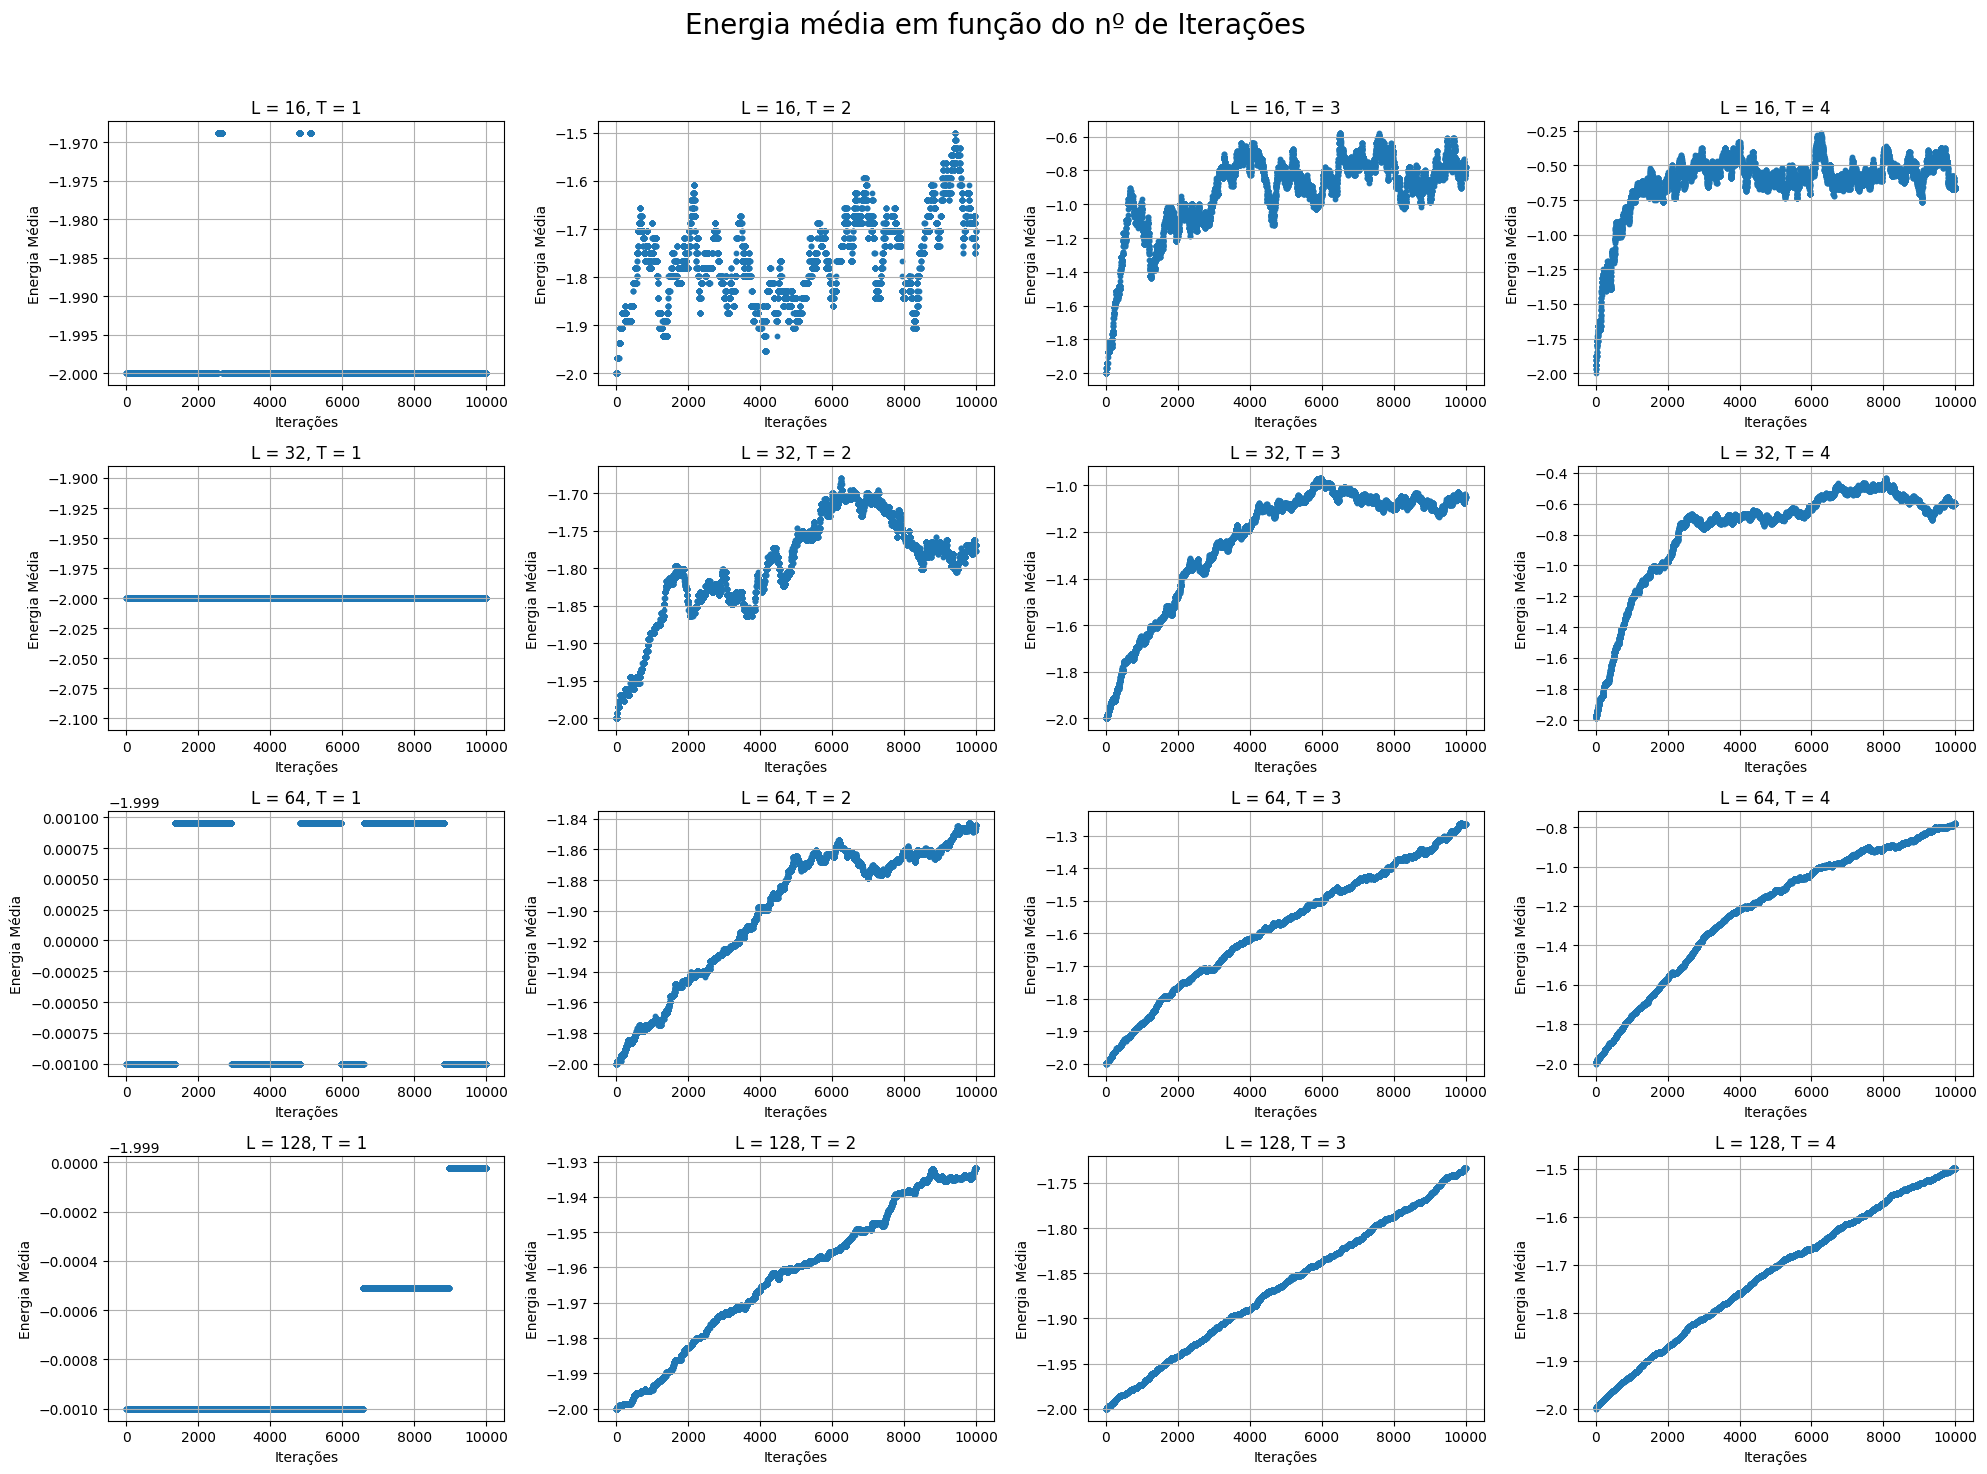

In [27]:
L_array = np.array([16, 32, 64, 128])
T_array = np.array([1, 2, 3, 4])
N_iter = 10000

fig, axes = plt.subplots(len(L_array), len(T_array), figsize=(20, 15))
fig.suptitle('Energia média em função do nº de Iterações', fontsize=20)

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N_iter)
        avg_ener = np.array(ising.energies[1:])/(L*L)

        ax = axes[i, j]
        ax.scatter(np.arange(1, N_iter + 1), avg_ener, s=10)
        ax.set_title(f'L = {L}, T = {T}')
        ax.set_xlabel('Iterações')
        ax.set_ylabel('Energia Média')
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**b)** Com o módulo scipy.optimize, ajustámos aos dados anteriores uma função como a descrita no enunciado, determinando os parâmetros `ef` e $\tau$, que são depois guardados no dicionário `fit_results`. Relativamente ao initial guess dado para os parâmetros: o ef foi escolhido como a média dos últimos 10% de valores; para escolher o tau, começámos por inverter a equação (4) do enunciado, para obter:

$$
\tau_{term} = - \frac{N}{\log\left( \frac{e(N)-e_f}{e_0-e_f} \right)}
$$

Para evitar erros, temos de garantir que $e_0-e_f \neq 0$ e que o argumento do logaritmo é estritamente maior que 0 e diferente de 1 (no código assinalamos essas condições com `#(1)`). Nos casos em que obtemos um erro do primeiro tipo tomamos como guess para tau um valor muito alto, para compensar pelo facto de os finais 10% de valores terem média igual à mínima energia. Fazemos o mesmo para um erro do terceiro tipo. No final fazemos a média dos taus obtidos (caso haja algum elemento determinado sem os erros que descrevemos).

In [28]:
def ener_func(N, ef, tau):
    return ef + (e0 - ef) * np.exp(-N / tau)

def guesses_for_ef_and_tau(energy_vals, n_points):

    #o guess para ef será a média dos últimos 10% de valores
    ef_guess = np.mean(avg_ener[-int(0.1 * len(avg_ener)):])

    #o guess para tau será resultante de inverter a equação, usando ef_guess
    e0 = energy_vals[0]

    if e0 - ef_guess == 0: #(1)
        return [ef_guess, 10**5]
    
    indices = np.random.choice(np.arange(1, len(energy_vals)), size=n_points, replace=False)
    taus = []
    for i in indices:
        if energy_vals[i] < ef_guess and energy_vals[i]-ef_guess != e0 - ef_guess: #(1)
            tau = -i / np.log((energy_vals[i]-ef_guess)/ (e0 - ef_guess))
            taus.append(tau)

    if taus: #caso a lista seja não vazia
        return [ef_guess, np.mean(taus)]
    else:
        return [ef_guess, 10**5]
    

# Dicionário para guardar os parâmetros de ajuste
fit_results = {}

for i, L in enumerate(L_array):
    for j, T in enumerate(T_array):
        
        ising = IsingModel(L, T)
        ising.iter_monte_carlo(N)
        N_values = np.arange(0, N + 1)
        avg_ener = np.array(ising.energies) / (L * L)
        e0 = avg_ener[0]

        # Chamada do ajuste com estimativas iniciais
        parameters, _ = curve_fit(ener_func, N_values, avg_ener, p0=guesses_for_ef_and_tau(avg_ener, 10))
        ef, tau = parameters

        # A chave (L,T) estará associada a um dicionário onde se guardam os valores ef e tau
        fit_results[(L, T)] = {'ef': ef, 'tau': min(100000, tau)}

print("Resultados do ajuste (ef e tau):\n")
for (L, T), params in fit_results.items():
    ef = params['ef']
    tau = params['tau']
    print(f"L = {L}, T = {T}: ef = {ef:.5f}, tau = {tau:.2f}")

L=   128,T=4.000000: 100%|██████████| 10000/10000 [00:00<00:00, 115325.72it/s]

Resultados do ajuste (ef e tau):

L = 16, T = 1: ef = -1.99904, tau = 610.51
L = 16, T = 2: ef = -1.79379, tau = 293.45
L = 16, T = 3: ef = -0.75588, tau = 881.47
L = 16, T = 4: ef = -0.58990, tau = 432.19
L = 32, T = 1: ef = -1.99353, tau = 469.79
L = 32, T = 2: ef = -1.59042, tau = 7170.51
L = 32, T = 3: ef = -0.87807, tau = 2232.20
L = 32, T = 4: ef = -0.53893, tau = 1706.88
L = 64, T = 1: ef = 0.01414, tau = 100000.00
L = 64, T = 2: ef = -1.77764, tau = 7231.21
L = 64, T = 3: ef = -0.98878, tau = 8292.71
L = 64, T = 4: ef = -0.66674, tau = 5555.95
L = 128, T = 1: ef = -1.99895, tau = 2156.75
L = 128, T = 2: ef = -1.68548, tau = 37952.94
L = 128, T = 3: ef = -1.27477, tau = 20818.17
L = 128, T = 4: ef = -0.58182, tau = 21227.04


**c)** Representação Gráfica da função tau_term, com os resultados das alíneas anteriores. Para a representação gráfica de tau(L, T), optámos por duas formas distintas: uma delas através do plot de 4 gráficos distintos de "tempo de termalização em função da temperatura", um para cada L, e um plot da função interpolada à grid L T (excluindo a temperatura T=1 para facilitar a comparação entre diferentes zonas). Relativamente à análise destes dados, podemos dizer que, para temperaturas a partir de T=2, se verifica que o tempo de termalização aumenta com o L. Para temperaturas mais baixas, a equação (4) não fornece claramente um modelo adequado, pelo que a significância dos valores obtidos para tau não é muita (daí também termos excluído T=1 no segundo plot).

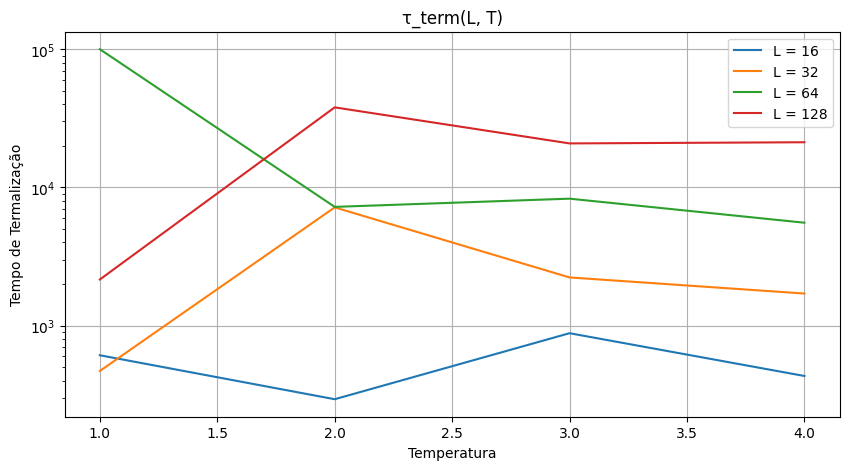

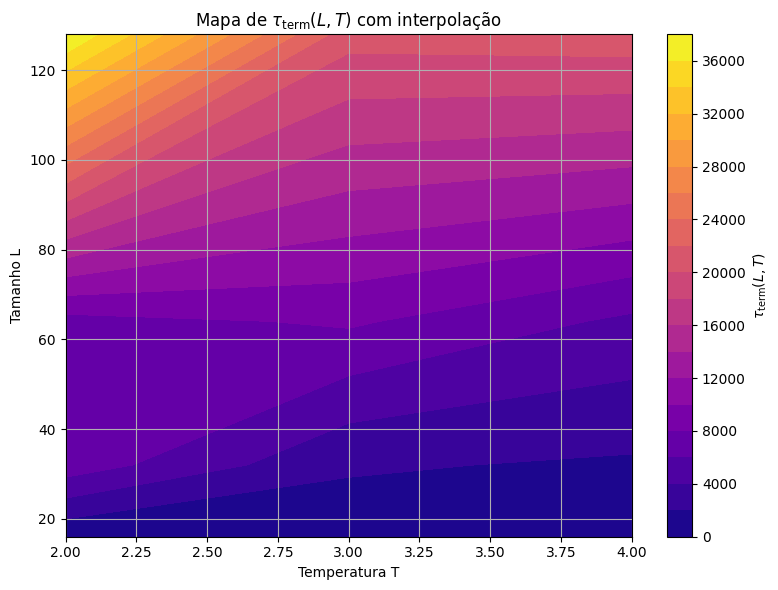

In [30]:
tau_array = np.array([[fit_results[l, t]['tau']  for t in T_array] for l in L_array])

plt.figure(figsize=(10, 5))

for i in range(len(L_array)):
    plt.plot(T_array, tau_array[i,], label=f'L = {L_array[i]}')

plt.title(f'τ_term(L, T)')
plt.yscale('log')
plt.xlabel('Temperatura')
plt.ylabel('Tempo de Termalização')
plt.legend()
plt.grid()
plt.show() 


interp_tau = RegularGridInterpolator((L_array, T_array), tau_array, bounds_error = False, method='cubic')

#Corrected Tau é apenas para visualização gráfico
corrected_tau_array = np.array([[fit_results[l, t]['tau']  for t in T_array if t != 1] for l in L_array])
corrected_interp_tau = RegularGridInterpolator((L_array, T_array[-3:]), corrected_tau_array, method='linear')

# Representação gráfica (mapa de calor ou contorno)
L_grid, T_grid = np.meshgrid(L_array, T_array[-3:], indexing='ij')

plt.figure(figsize=(8, 6))
cp = plt.contourf(T_grid, L_grid, corrected_tau_array, levels=20, cmap='plasma')
plt.colorbar(cp, label=r'$\tau_{\mathrm{term}}(L,T)$')
plt.xlabel('Temperatura T')
plt.ylabel('Tamanho L')
plt.title(r'Mapa de $\tau_{\mathrm{term}}(L, T)$ com interpolação')
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Determinação da Temperatura Crítica

**a)** 

L=128: 100%|██████████| 16/16 [02:49<00:00, 10.60s/it]


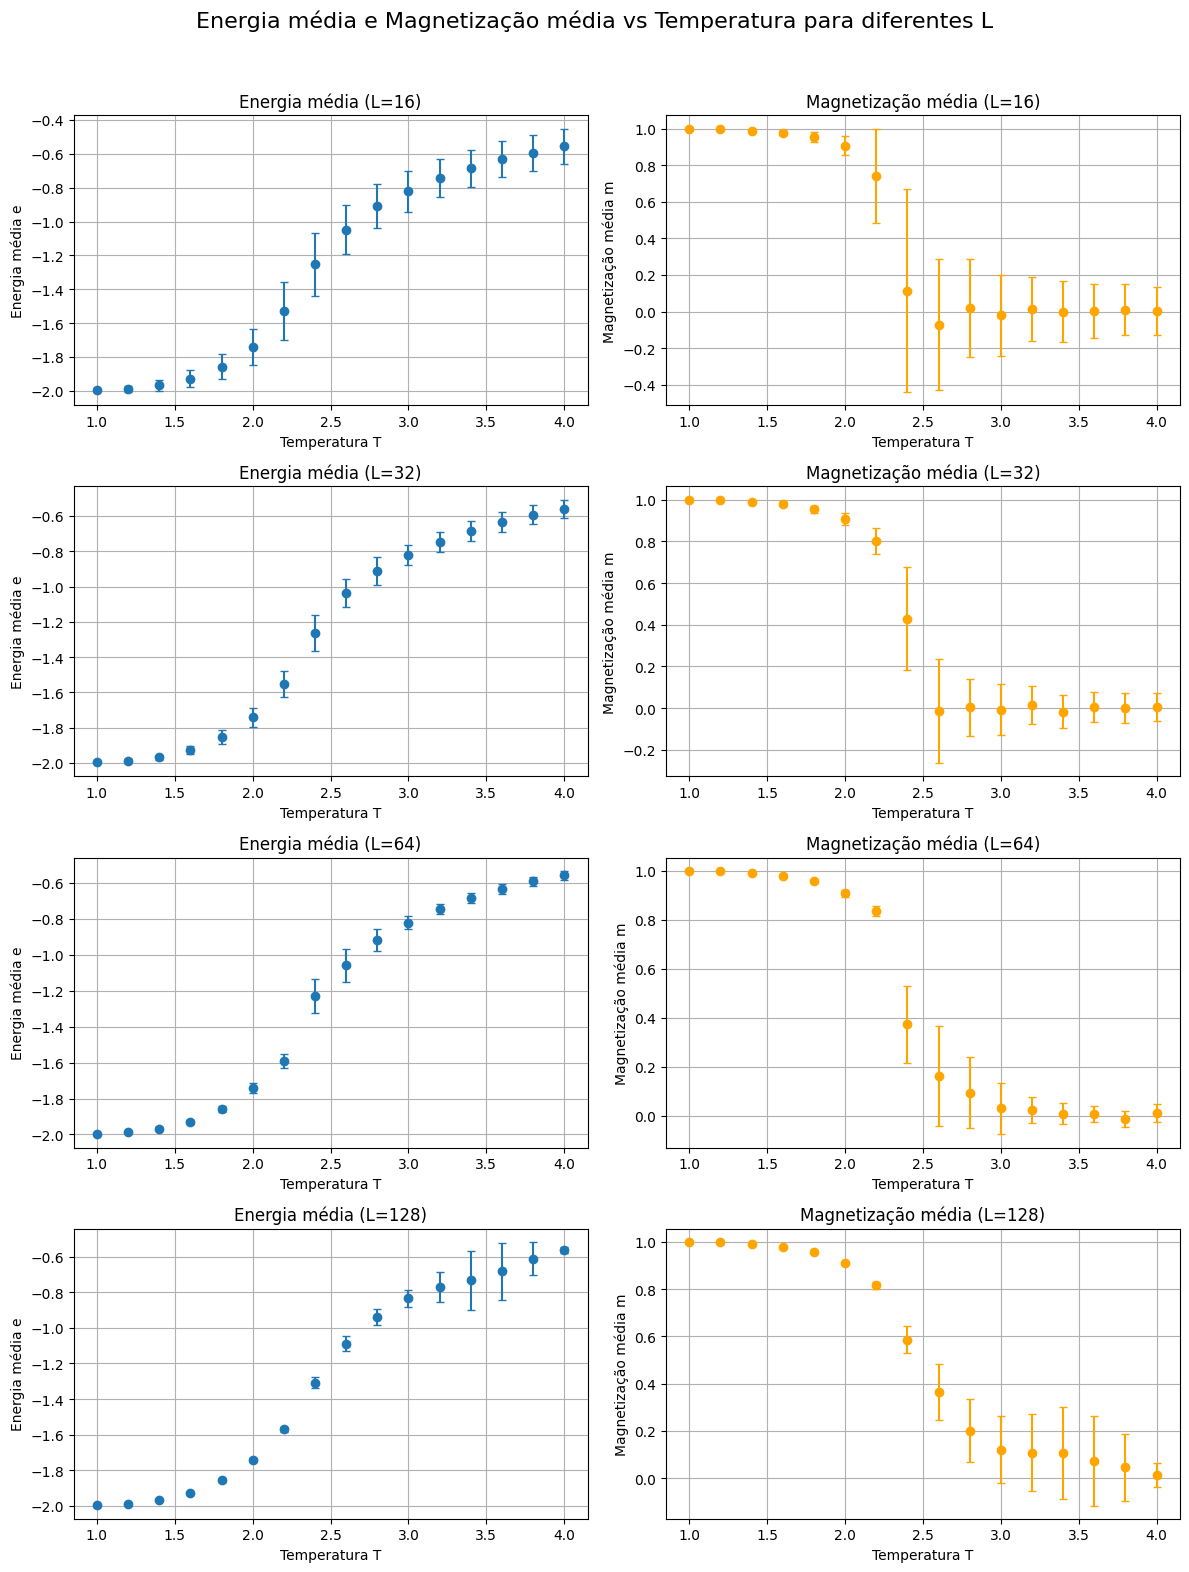

In [11]:
h = 0.2
T_values = np.arange(1, 4.1, h)
N_measurements = 1000000 #alterar para 1 000 000

# Iremos armazenar os resultados no seguinte dicionário:
results = {L: {'T': [], 'e_mean': [], 'e2_mean': [], 'e_std': [], 'm_mean': [], 'm_std': []} for L in L_array}

fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle('Energia média e Magnetização média vs Temperatura para diferentes L', fontsize=16)

for i, L in enumerate(L_array):
    for T in tqdm(T_values, desc=f"L={L}"):
        ising = IsingModel(L, T)
        N_term = int(4*interp_tau((L,T)))
        ising.iter_monte_carlo(N_term + N_measurements)
        
        energies = np.array(ising.energies[-N_measurements:])/(L*L)
        magnetizations = np.array(ising.magnetizations[-N_measurements:])/(L*L)
        
        e_mean = np.mean(energies)
        e_squared_mean = np.mean(energies**2) # para 2c
        e_std = np.std(energies)
        m_mean = np.mean(magnetizations)
        m_std = np.std(magnetizations)
        
        results[L]['e_mean'].append(e_mean)
        results[L]['e2_mean'].append(e_squared_mean)
        results[L]['e_std'].append(e_std)
        results[L]['m_mean'].append(m_mean)
        results[L]['m_std'].append(m_std)

    #Para realizar o plot
    ax_e = axes[i, 0]
    ax_e.errorbar(T_values, results[L]['e_mean'], yerr=results[L]['e_std'], fmt='o', capsize=3, label=f'L={L}')
    ax_e.set_xlabel('Temperatura T')
    ax_e.set_ylabel('Energia média e')
    ax_e.set_title(f'Energia média (L={L})')
    ax_e.grid(True)
    ax_m = axes[i, 1]
    ax_m.errorbar(T_values, results[L]['m_mean'], yerr=results[L]['m_std'], fmt='o', capsize=3, color='orange', label=f'L={L}')
    ax_m.set_xlabel('Temperatura T')
    ax_m.set_ylabel('Magnetização média m')
    ax_m.set_title(f'Magnetização média (L={L})')
    ax_m.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**b)**

L = 16: Tc = 2.2 e c = 1.217145 +/- 0.532236
L = 32: Tc = 2.4 e c = 1.290127 +/- 0.269791
L = 64: Tc = 2.4 e c = 1.326701 +/- 0.244382
L = 128: Tc = 2.4 e c = 1.201387 +/- 0.115057


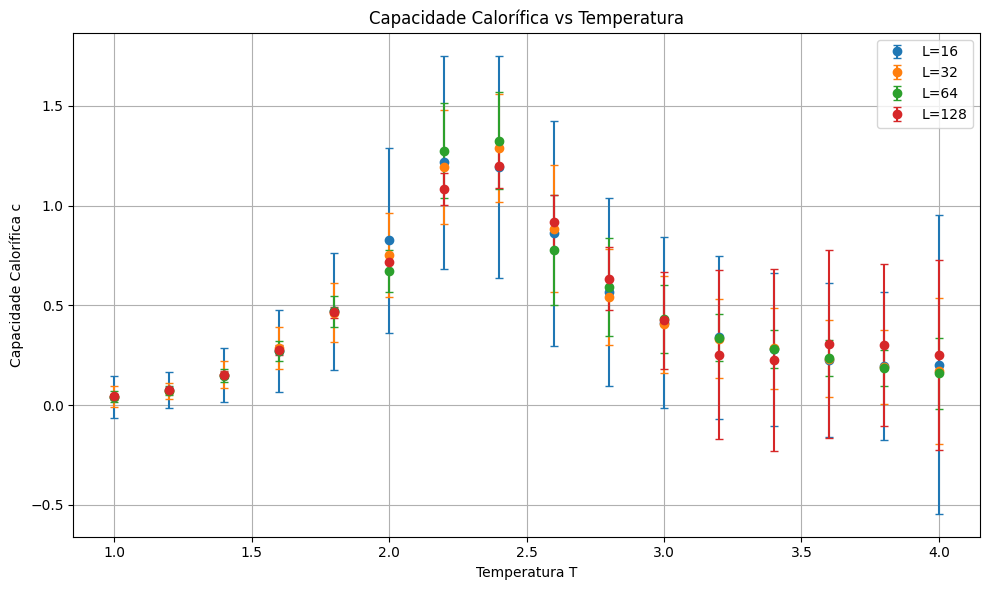

In [12]:
heat_capacities = {L: {'T': [], 'c': [], 'c_err': []} for L in L_array}

def discrete_derivative_for_data(T, Y, Y_err):
    if len(T) != len(Y):
        raise ValueError("T and Y must have the same length")
    dY_values = [(Y[1]-Y[0])/(T[1]-T[0])]
    Err_values = [np.sqrt(Y_err[0]*Y_err[0] + Y_err[1]*Y_err[1])/(T[1]-T[0])]
    for i in range(1, len(T)-1):
        dY_values.append((Y[i+1]-Y[i-1])/(T[i+1]-T[i-1]))
        Err_values.append(np.sqrt(Y_err[i-1]*Y_err[i-1] + Y_err[i+1]*Y_err[i+1])/(T[i+1]-T[i-1]))
    dY_values.append((Y[-1]-Y[-2])/(T[-1]-T[-2]))
    Err_values.append(np.sqrt(Y_err[-1]*Y_err[-1] + Y_err[-2]*Y_err[-2])/(T[-1]-T[-2]))
    return dY_values, Err_values

for L in L_array:
    c_values, c_error = discrete_derivative_for_data(T_values, results[L]['e_mean'], results[L]['e_std'])
    heat_capacities[L]['T'] = results[L]['T']
    heat_capacities[L]['c'] = c_values
    heat_capacities[L]['c_err'] = c_error
    idx_max = np.argmax(heat_capacities[L]['c'])
    Tc = T_values[idx_max]
    c, Error = heat_capacities[L]['c'][idx_max], heat_capacities[L]['c_err'][idx_max]
    print(f"L = {L}: Tc = {Tc:.1f} e c = {c:.6f} +/- {Error:.6f}")


# Plot da capacidade calorífica em função de T, com barras de erro

plt.figure(figsize=(10, 6))

for L in L_array:
    plt.errorbar(T_values, heat_capacities[L]['c'], yerr=heat_capacities[L]['c_err'], fmt='o', capsize=3, label=f'L={L}')

plt.xlabel('Temperatura T')
plt.ylabel('Capacidade Calorífica c')
plt.title('Capacidade Calorífica vs Temperatura')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**c)** Capacidade calorífica calculada a partir da base estatística do método de Metropolis-Hastings. Nota Importante sobre a fórmula utilizada: uma vez que as `energies` já calculadas são na verdade as energias médias por spin, temos que: 

$$
\frac{\langle E^2 \rangle- \langle E \rangle^2}{T^2 L^2} = L^2 \frac{\langle e^2 \rangle- \langle e \rangle^2}{T^2}
$$

pelo que será esta a fórmula utilizada. Aproveitamos para fazer nesta secção uma análise mais detalhada dos valores obtidos: através do primeiro método, obtivémos as seguintes 3-plas `(L, Tc)`: `(16, 2.2), (32, 2.2), (64, 2.2), (128, 2.4)`, o que dá a seguinte Temperatura crítica média $T_c = 2.25$. Através do segundo método, obtivémos a Temperatura crítica média $T_c = 2.392$, que está bastante próxima e concordante com a determinada pelo primeiro.

In [13]:
c_vals = {L:[] for L in L_array}
stat_Tcs = {}
for L in L_array:
    for i, T in enumerate(T_values):
        c = L*L*(results[L]['e2_mean'][i] - results[L]['e_mean'][i]**2)/(T*T)
        c_vals[L].append(c)

    index_for_Tc = np.argmax(np.array(c_vals[L]))
    stat_Tc = T_values[index_for_Tc]
    stat_Tcs[L] = stat_Tc
    print(f"L = {L}: Tc = {stat_Tc:.1f}")

L = 16: Tc = 2.2
L = 32: Tc = 2.4
L = 64: Tc = 2.4
L = 128: Tc = 3.4


**d)** Modelação da capacidade calorífica a uma função como a da equação (7)

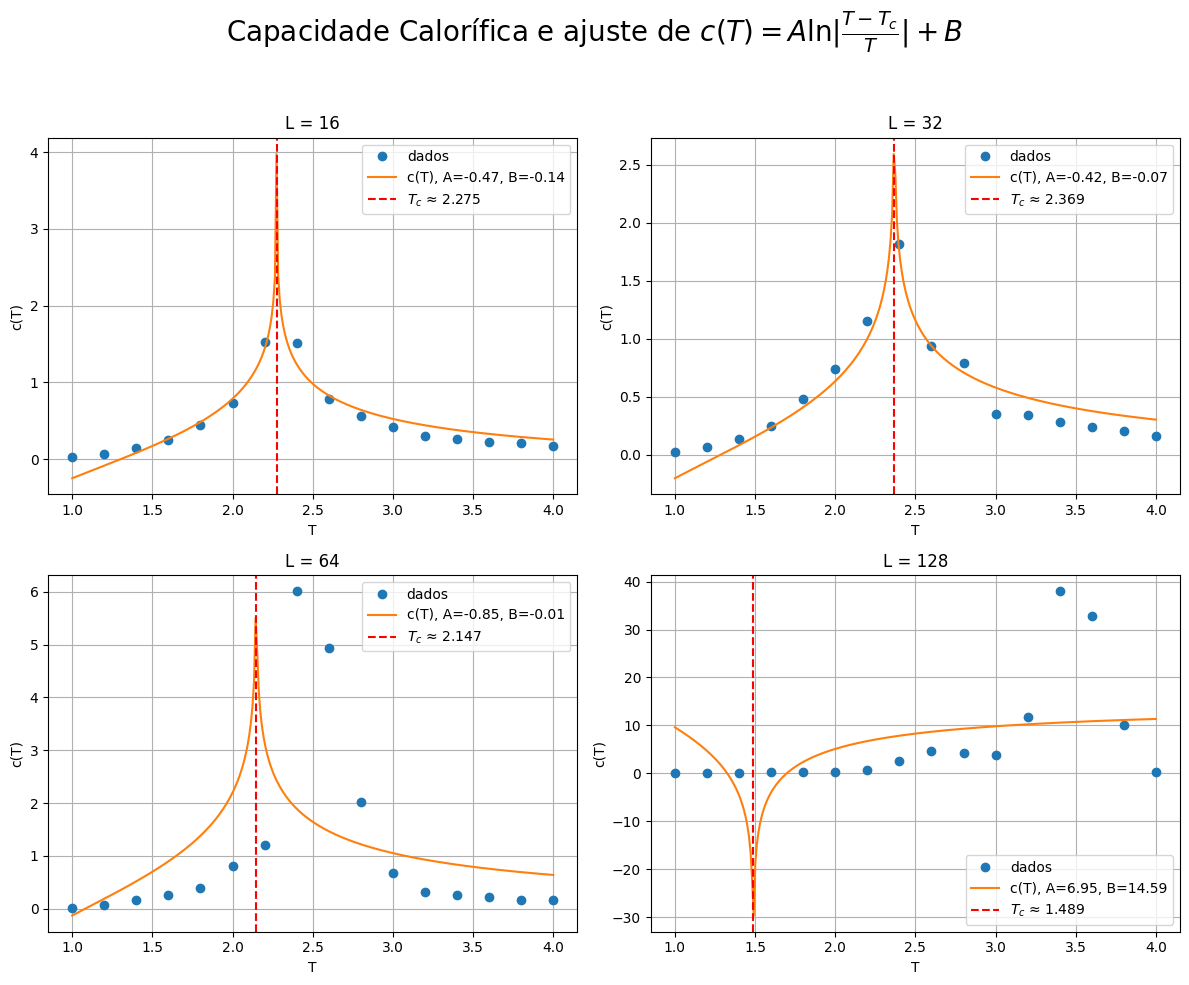

In [14]:
def c_model(T, A, B, Tc):
    return A * np.log(np.abs((T - Tc) / T)) + B

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Capacidade Calorífica e ajuste de $c(T) = A \\ln|\\frac{T - T_c}{T}| + B$', fontsize=20)

L_list = [16, 32, 64, 128]
for j, L in enumerate(L_list):
    T = np.array(T_values)
    c = np.array(c_vals[L])

    
    parameters, _ = curve_fit(c_model, T, c, p0=[1.0, 0.1, 2.3])
    A, B, Tc = parameters

    ax = axes[j // 2, j % 2]
    T_fine = np.linspace(min(T), max(T), 300)
    ax.plot(T, c, 'o', label='dados')
    ax.plot(T_fine, c_model(T_fine, *parameters), '-', label=f'c(T), A={A:.2f}, B={B:.2f}')
    ax.axvline(Tc, color='r', linestyle='--', label=f'$T_c$ ≈ {Tc:.3f}')
    ax.set_title(f'L = {L}')
    ax.set_xlabel('T')
    ax.set_ylabel('c(T)')
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 3. Determinação da Energia Livre de Helmholtz, F

**a)** Para calcular a energia livre de Helmholtz, precisamos de saber a energia média e N, em que $N_{term} = 4\tau_{term}$. Neste caso, fixamos L em 128.

L=   128,T=10.000000: 100%|██████████| 10/10 [00:00<00:00, 37150.61it/s]
/var/folders/95/nwjkc2t962bbd0wkb2vkccbc0000gn/T/ipykernel_28393/367894811.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # legenda


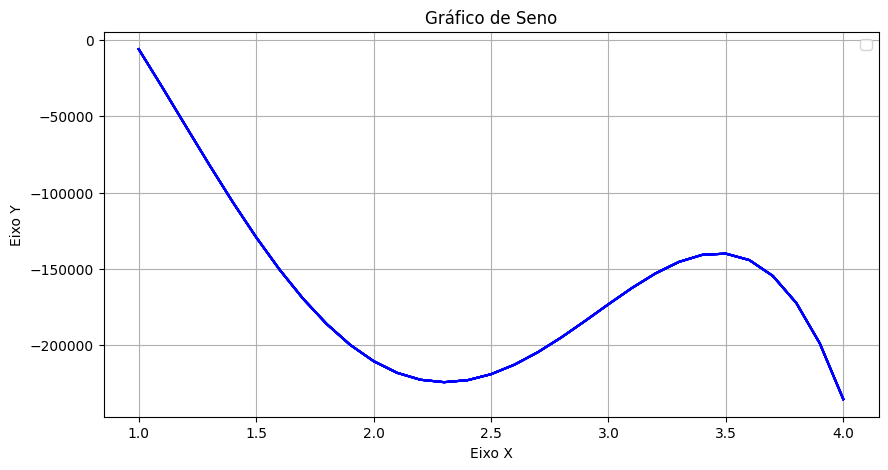

In [33]:
#Função calcula a energia livre de helmholtz para T e L determinados
def helmholtz(L, T, n):

    t_array = np.linspace(T, 10, n)
    integ_array = np.empty((len(t_array),)) #Array dos integrandos
    
    #O loop define o integrando para cada T (energ/temp^2)
    for t in t_array:
        #Correr simulação
        h_ising = IsingModel(L, t)
        h_ising.iter_monte_carlo(n)

        #Calcular termo integrando
        energy = h_ising.calc_ener()
        integ = energy/(t**2)
        i = np.where(t_array == t)
        integ_array[i] = integ
    
    condition = np.array([L,T])
    N = 4 * interp_tau(condition)
    integral = cumulative_trapezoid(integ_array, t_array)

    return T*(integral - N*np.log(2))

#Definir L e n
L = 128
n = 10

#Definir arrays das coordenadas
T_array = np.arange(0.1, 10, 0.1)
F_array = np.array([helmholtz(L, temp, n) for temp in T_array])

#Plotar gráfico
plt.figure(figsize=(10, 5)) # tamanho da figura

plt.plot(T_array, F_array, label='', color='blue') # plotando a função seno
plt.title('Gráfico de Seno') # título do gráfico
plt.xlabel('Eixo X') # rótulo do eixo x
plt.ylabel('Eixo Y') # rótulo do eixo y
plt.legend() # legenda
plt.grid() # grelha
plt.show() # mostrando o gráfico

**b)** Para interpolar a função

In [34]:
F_interpol = CubicSpline(T_array, F_array)
null_F = F_interpol.roots()

print(null_F)

plt.figure(figsize=(10, 5)) # tamanho da figura

plt.plot(T_array, F_interpol(T_array), label='Seno', color='blue') # plotando a função seno
plt.title('Gráfico de Seno') # título do gráfico
plt.xlabel('Eixo X') # rótulo do eixo x
plt.ylabel('Eixo Y') # rótulo do eixo y
plt.legend() # legenda
plt.grid() # grelha
plt.show() # mostrando o gráfic

ValueError: `y` must contain only finite values.

**c)**

In [ ]:
deriv2 = F_interpol.derivative[2]

plt.figure(figsize=(10, 5)) # tamanho da figura

plt.plot(T_array, deriv2(T_array), label='Seno', color='blue') # plotando a função seno
plt.title('Gráfico de Seno') # título do gráfico
plt.xlabel('Eixo X') # rótulo do eixo x
plt.ylabel('Eixo Y') # rótulo do eixo y
plt.legend() # legenda
plt.grid() # grelha
plt.show() # mostrando o gráfico